In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Gordon


No vtk


In [2]:
stack_fixed = 'MD642'
stack_moving = 'atlasV2'

In [3]:
classifier_setting = 2
warp_setting = 1

In [4]:
if warp_setting == 1:
    upstream_warp_setting = None
    transform_type = 'affine'
elif warp_setting == 2:
    upstream_warp_setting = 1
    transform_type = 'rigid'
else:
    raise Exception('Warp setting not recognized.')

In [5]:
grad_computation_sample_number = 1e5
grid_search_sample_number = 1000
grid_search_iteration_number = 30
std_tx = 50
std_ty = 50
std_tz = 50
std_theta_xy = np.deg2rad(10)

In [6]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_score_volume_all_known_structures(stack=stack_moving, sided=True)

print volume_moving[1].shape

(344, 418, 373)


File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.


In [7]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)

print volume_fixed[1].shape

(487, 600, 387)


File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_2/score_volumes/MD642_down32_scoreVolume_clf_2_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_2/score_volumes/MD642_down32_scoreVolume_clf_2_sp5.bp
Score volume for sp5 does not exist.


In [8]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R', 'Pn_L', 'Pn_R', 'SNR_L', 'SNR_R',
                                  'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_L',
                                  'VCA_R', 'VCP_R']}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [9]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [10]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [11]:
label_weights_m = {}
for label_m, name_m in label_to_structure_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1
#         label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

# Compute Registration

In [12]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [13]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

In [14]:
gradient_filepath_map_f = {ind_f: DataManager.get_score_volume_gradient_filepath_template(\
                            stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                            downscale=32, classifier_setting=classifier_setting)
                           for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [15]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([2, 5, 7, 8, 16, 21, 25, 26, 27, 28])


load gradient 2: 3.897755 seconds
load gradient 5: 3.995346 seconds
load gradient 7: 4.026175 seconds
load gradient 8: 4.357387 seconds
load gradient 16: 4.111798 seconds
load gradient 21: 4.128352 seconds
load gradient 25: 3.644358 seconds
load gradient 26: 3.857940 seconds
load gradient 27: 3.824490 seconds
load gradient 28: 3.935699 seconds
overall: 39.780616 seconds


In [16]:
aligner.set_label_weights(label_weights=label_weights_m)

In [17]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:
for _ in range(1):

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=1000, history_len=10, 
                                     terminate_thresh=1e-4,
                                     indices_m=None,
                                     grid_search_iteration_number=grid_search_iteration_number,
                                     grid_search_sample_number=grid_search_sample_number,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=10, lr2=0.1,
                                     std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)
        
        break
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


grid search: 11.473692 seconds
-inf 0.536686
grid search: 8.448045 seconds
0.536686 0.586947
grid search: 6.231539 seconds
0.586947 0.600036
grid search: 4.429210 seconds
0.600036 0.627045
grid search: 3.623656 seconds
0.627045 0.634800
grid search: 2.424417 seconds
grid search: 1.919907 seconds
grid search: 1.318376 seconds
grid search: 1.118051 seconds
grid search: 0.917270 seconds
0.634800 0.634997
grid search: 0.817519 seconds
0.634997 0.635384
grid search: 0.621692 seconds
0.635384 0.635539
grid search: 0.514007 seconds
grid search: 0.405061 seconds
0.635539 0.635777
grid search: 0.415285 seconds
0.635777 0.635869
grid search: 0.416450 seconds
grid search: 0.314544 seconds
0.635869 0.635893
grid search: 0.313186 seconds
grid search: 0.315262 seconds
0.635893 0.635903
grid search: 0.313227 seconds
0.635903 0.635978
grid search: 0.320426 seconds
grid search: 0.311443 seconds
grid search: 0.304470 seconds
grid search: 0.319141 seconds
grid search: 0.312404 seconds
grid search: 0.3195

params_best_upToNow [ 39.95521672 -31.193648     3.67943165  -0.31136568]


step: 0.56 seconds
score: 0.635978
iteration 1
step: 0.57 seconds
score: 0.402916
iteration 2
step: 0.55 seconds
score: 0.343942
iteration 3
step: 0.56 seconds
score: 0.475640
iteration 4
step: 0.56 seconds
score: 0.483206
iteration 5
step: 0.55 seconds
score: 0.458426
iteration 6
step: 0.55 seconds
score: 0.628801
iteration 7
step: 0.55 seconds
score: 0.597116
iteration 8
step: 0.55 seconds
score: 0.587292
iteration 9
step: 0.55 seconds
score: 0.610287
iteration 10
step: 0.56 seconds
score: 0.552266
iteration 11
step: 0.55 seconds
score: 0.592819
iteration 12
step: 0.55 seconds
score: 0.589240
iteration 13
step: 0.55 seconds
score: 0.598721
iteration 14
step: 0.55 seconds
score: 0.635326
iteration 15
step: 0.55 seconds
score: 0.620468
iteration 16
step: 0.55 seconds
score: 0.641982
iteration 17
step: 0.55 seconds
score: 0.632419
iteration 18
step: 0.55 seconds
score: 0.647682
iteration 19
step: 0.55 seconds
score: 0.640422
iteration 20
step: 0.55 seconds
score: 0.650888
iteration 21
s

[[  1.01409818e+00   3.86926317e-01  -3.72102497e-02   2.75477623e+01]
 [ -3.48053454e-01   1.00252211e+00  -1.04326072e-02  -5.03462657e+01]
 [ -9.42639140e-03   5.32517379e-02   9.89741848e-01  -2.52050887e-01]]
0.671886667609 0.671385204419


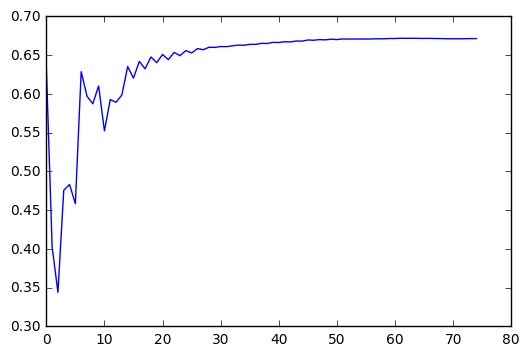

In [18]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

# Export parameters and score plots

In [19]:
params_fp = \
DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                              classifier_setting_m=classifier_setting,
                                              classifier_setting_f=classifier_setting,
                                              warp_setting=warp_setting,
                                              trial_idx=0)

DataManager.save_alignment_parameters(params_fp, T, 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

score_plot_fp = \
DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                     classifier_setting_m=classifier_setting,
                                                     classifier_setting_f=classifier_setting,
                                                     warp_setting=warp_setting,
                                                     trial_idx=0)
fig = plt.figure();
plt.plot(scores);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)